In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, make_scorer, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, average_precision_score
from scipy.stats import randint, uniform
from sklearn.model_selection import cross_validate, cross_val_predict

In [2]:
X = pd.read_csv('X.csv')
y = pd.read_csv('y.csv')

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  
)
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Fraud ratio in train:", y_train.mean())
print("Fraud ratio in test:", y_test.mean())

Train shape: (12336, 44)
Test shape: (3084, 44)
Fraud ratio in train: FraudFound_P    0.059825
dtype: float64
Fraud ratio in test: FraudFound_P    0.059987
dtype: float64


In [4]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),              
    ('resample', SMOTEENN(random_state=42)),  
    ('xgb', XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=42,
    ))
])

In [5]:
param_dist = {
    'xgb__n_estimators': randint(300, 800),
    'xgb__max_depth': randint(3, 10),
    'xgb__learning_rate': uniform(0.01, 0.2),
    'xgb__subsample': uniform(0.6, 0.4),
    'xgb__colsample_bytree': uniform(0.6, 0.4),
    'xgb__min_child_weight': randint(1, 10),
    'xgb__gamma': uniform(0, 0.5)
}

In [6]:
pr_auc_scorer = make_scorer(average_precision_score, needs_proba=True)
scoring = pr_auc_scorer

In [7]:
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=40,
    scoring=scoring,
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

In [8]:
random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print(f"Best CV PR-AUC: {random_search.best_score_:.4f}")

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Parameters: {'xgb__colsample_bytree': 0.9329770563201687, 'xgb__gamma': 0.10616955533913808, 'xgb__learning_rate': 0.04636499344142013, 'xgb__max_depth': 7, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 759, 'xgb__subsample': 0.8446612641953124}
Best CV PR-AUC: 0.4814


In [9]:
cv_scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score, needs_proba=True),
    'pr_auc': make_scorer(average_precision_score, needs_proba=True)   
}

cv_results = cross_validate(
    random_search.best_estimator_,
    X_train,
    y_train,
    scoring=cv_scoring,
    cv=5
)


In [10]:
metric_table = pd.DataFrame(cv_results)

In [11]:
metric_table

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc,test_pr_auc
0,1.447728,0.039556,0.939627,0.496933,0.547297,0.520900,0.939265,0.485328
1,1.378333,0.040064,0.936765,0.471698,0.510204,0.490196,0.948006,0.500171
2,1.392327,0.039053,0.932712,0.444444,0.517007,0.477987,0.920200,0.428672
3,1.471155,0.042060,0.945278,0.540373,0.587838,0.563107,0.935235,0.511539
4,1.418967,0.041056,0.935955,0.469136,0.513514,0.490323,0.921885,0.499321


In [12]:
print("\nMean Recall across folds:", metric_table['test_recall'].mean())


Mean Recall across folds: 0.5351719066004781


In [13]:
print("\nMean Precision across folds:", metric_table['test_precision'].mean())


Mean Precision across folds: 0.4845167092532009


In [14]:
print("\nMean Precision across folds:", metric_table['test_pr_auc'].mean())


Mean Precision across folds: 0.4850063851535601


In [15]:
y_pred_cv = cross_val_predict(
    random_search.best_estimator_,
    X_train, y_train,
    cv=5,
    method='predict'
)
cm = confusion_matrix(y_train, y_pred_cv)
print(cm)


[[11177   421]
 [  343   395]]


In [16]:
print(classification_report(y_train, y_pred_cv))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97     11598
           1       0.48      0.54      0.51       738

    accuracy                           0.94     12336
   macro avg       0.73      0.75      0.74     12336
weighted avg       0.94      0.94      0.94     12336



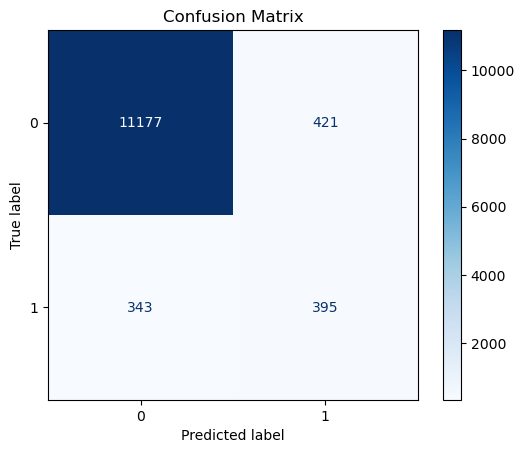

In [17]:
disp = ConfusionMatrixDisplay(cm, display_labels=[0,1])
disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix")
plt.show()

In [18]:
best_model = random_search.best_estimator_
y_prob = best_model.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)
print(f"Test Recall: {recall_score(y_test, y_pred):.4f}")
test_pr_auc = average_precision_score(y_test, y_prob)
print("Test PR-AUC:", test_pr_auc)
print(confusion_matrix(y_test, y_pred))

Test Recall: 0.6054
Test PR-AUC: 0.5775324165629605
[[2784  115]
 [  73  112]]


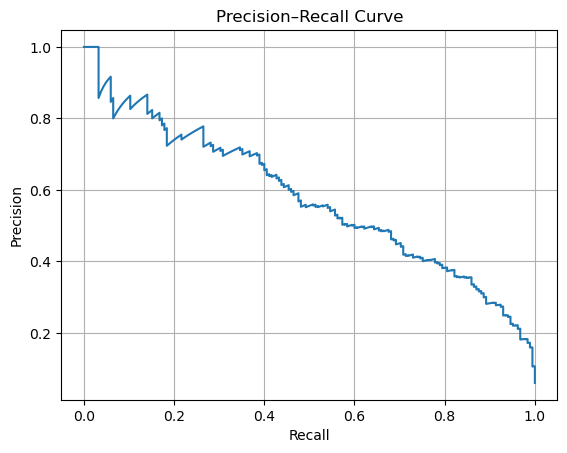

In [37]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.grid(True)
plt.show()
